## Importing the required libraries

In [102]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [103]:
from keras import regularizers

In [104]:
import os

In [105]:
mylist= os.listdir('audiodata/')

In [106]:
type(mylist)
print(len(mylist))

60


In [107]:
print(mylist[0])

03-01-01-01-01-01-01.wav


In [108]:
print(mylist[0][6:-16])

01


## Plotting the audio file's waveform and its spectrogram

In [109]:
data, sampling_rate = librosa.load('audiodata/03-01-01-01-01-01-01.wav')
print(data, sampling_rate)

[ 5.3765390e-08 -2.1233145e-08 -6.0478342e-09 ...  4.8083174e-14
 -9.6233243e-15  2.8714739e-14] 22050


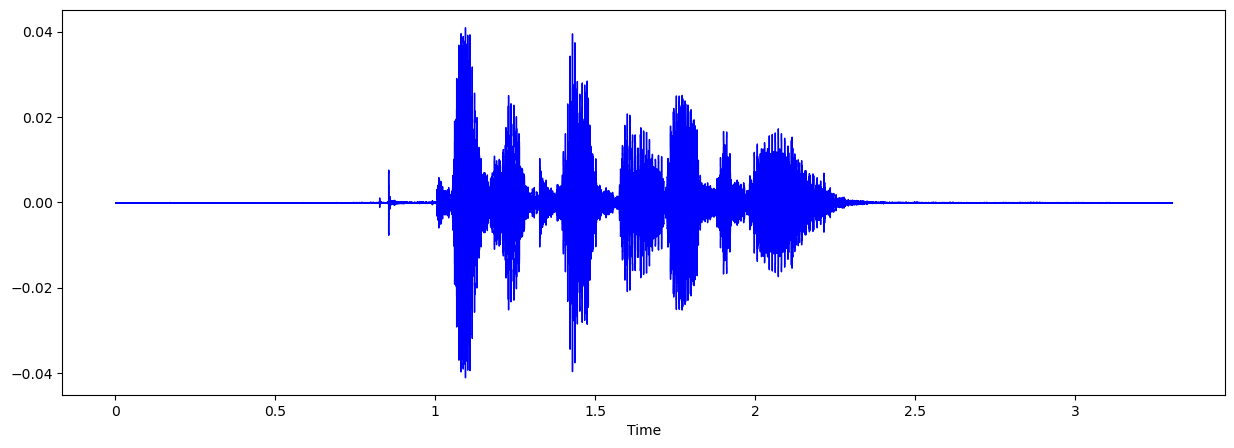

In [110]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate, color="blue")

C:\Users\shash\AppData\Local\Temp\ipykernel_29436\2277719712.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('audiodata/03-01-01-01-01-01-01.wav')
C:\Users\shash\AppData\Local\Temp\ipykernel_29436\2277719712.py:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


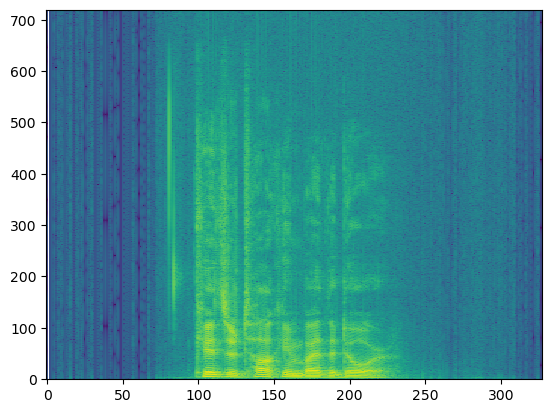

In [111]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('audiodata/03-01-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [112]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [113]:
labels = pd.DataFrame(feeling_list)

In [114]:
labels[:10]

,0
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_happy
9,male_happy


## Getting the features of audio files using librosa

In [115]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('audiodata/'+y, offset=0.5, duration=2.5, sr=22050*2, res_type='kaiser_fast')
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [116]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-67.55767, -67.55767, -67.55767, -67.55767, -..."
2,"[-69.69336, -69.69336, -69.69336, -69.69336, -..."
3,"[-69.051476, -69.051476, -69.051476, -69.05147..."
4,"[-73.84186, -73.84186, -73.84186, -73.72008, -..."


In [117]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [118]:
newdf = pd.concat([df3,labels], axis=1)

In [119]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [120]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-57.271214,-56.744106,-56.141361,-57.532471,-59.493530,-67.150169,-67.499031,-66.098358,-66.741074,male_calm
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-61.018982,-60.341557,-63.465752,-64.500572,-61.647270,-58.001892,-58.848892,-62.756329,-62.829971,male_calm
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-57.682072,-56.301693,-58.650570,-63.881496,-63.749794,-65.222809,-65.308594,-67.015755,-68.824036,male_calm
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-50.570274,-53.508457,-54.224915,-51.547527,-52.576477,-54.788902,-56.346535,-57.488159,-57.013565,male_calm


In [121]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
8,-63.787254,-63.128746,-63.412743,-63.797016,-63.582291,-58.921696,-57.955513,-61.225422,-63.783241,-63.797016,...,-62.505516,-59.519352,-60.482807,-58.339035,-58.965763,-63.520969,-63.769627,-63.828476,-63.581627,male_happy
17,-67.736496,-67.775078,-66.746597,-65.958344,-67.736496,-67.736496,-67.736496,-67.259163,-67.736496,-67.736496,...,-61.116722,-63.291748,-65.844711,-65.121506,-59.515804,-59.591988,-66.712601,-67.736496,-67.736496,male_sad
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
20,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,...,-41.763573,-43.195366,-44.881939,-45.718025,-48.605755,-53.019157,-49.684017,-51.019474,-57.277859,male_sad
26,-56.165428,-56.166897,-56.158165,-54.663876,-55.167160,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265,...,-56.157265,-56.157265,-56.157265,-55.844578,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265,male_angry
18,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,...,-70.229752,-70.229752,-70.229752,-70.229752,-66.133965,-62.637821,-66.394821,-70.229752,-70.229752,male_sad
30,-49.255302,-48.947533,-49.051529,-49.020500,-49.043743,-49.089008,-47.905560,-47.956841,-48.153133,-48.783493,...,-19.783306,-19.593184,-19.809538,-21.997789,-21.924908,-23.150217,-23.046072,-21.830202,-21.201841,male_angry
29,-43.212883,-42.336555,-44.168678,-43.173862,-43.591530,-42.570889,-43.202141,-43.710686,-43.444176,-43.015842,...,-22.873741,-20.374416,-17.856462,-16.366428,-14.621313,-18.455235,-21.158491,-13.505090,-8.131514,male_angry
32,-37.918861,-41.258499,-47.775944,-45.638657,-45.101887,-48.043533,-48.737446,-48.717079,-49.199280,-49.100506,...,-56.839233,-54.096859,-53.427769,-59.046432,-57.350243,-58.454796,-59.379673,-60.010906,-60.010906,male_fearful
38,-41.921913,-41.239151,-41.299171,-42.205261,-42.010677,-42.346931,-41.992268,-40.100216,-38.743668,-38.762974,...,-23.336887,-23.642174,-24.690920,-27.676052,-29.822889,-30.354042,-30.983870,-29.805061,-30.051144,male_fearful


In [122]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [123]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [124]:
train[0:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
8,-63.787254,-63.128746,-63.412743,-63.797016,-63.582291,-58.921696,-57.955513,-61.225422,-63.783241,-63.797016,...,-62.505516,-59.519352,-60.482807,-58.339035,-58.965763,-63.520969,-63.769627,-63.828476,-63.581627,male_happy
17,-67.736496,-67.775078,-66.746597,-65.958344,-67.736496,-67.736496,-67.736496,-67.259163,-67.736496,-67.736496,...,-61.116722,-63.291748,-65.844711,-65.121506,-59.515804,-59.591988,-66.712601,-67.736496,-67.736496,male_sad
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
20,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,-65.756218,...,-41.763573,-43.195366,-44.881939,-45.718025,-48.605755,-53.019157,-49.684017,-51.019474,-57.277859,male_sad
26,-56.165428,-56.166897,-56.158165,-54.663876,-55.167160,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265,...,-56.157265,-56.157265,-56.157265,-55.844578,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265,male_angry
18,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,-70.229752,...,-70.229752,-70.229752,-70.229752,-70.229752,-66.133965,-62.637821,-66.394821,-70.229752,-70.229752,male_sad
32,-37.918861,-41.258499,-47.775944,-45.638657,-45.101887,-48.043533,-48.737446,-48.717079,-49.199280,-49.100506,...,-56.839233,-54.096859,-53.427769,-59.046432,-57.350243,-58.454796,-59.379673,-60.010906,-60.010906,male_fearful
38,-41.921913,-41.239151,-41.299171,-42.205261,-42.010677,-42.346931,-41.992268,-40.100216,-38.743668,-38.762974,...,-23.336887,-23.642174,-24.690920,-27.676052,-29.822889,-30.354042,-30.983870,-29.805061,-30.051144,male_fearful
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-61.018982,-60.341557,-63.465752,-64.500572,-61.647270,-58.001892,-58.848892,-62.756329,-62.829971,male_calm
7,-70.746674,-70.746674,-70.025597,-69.131645,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,...,-32.432106,-32.476925,-34.336796,-38.283310,-39.113003,-41.012882,-40.284622,-41.448433,-46.435349,male_calm


In [125]:
trainfeatures = train.iloc[:, :-1]

In [126]:
trainlabel = train.iloc[:, -1:]

In [127]:
testfeatures = test.iloc[:, :-1]

In [128]:
testlabel = test.iloc[:, -1:]

In [129]:
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


c:\Users\shash\miniconda3\envs\hacks\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shash\miniconda3\envs\hacks\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [130]:
print("Shape of y_train after transformation:", y_train.shape)
print("Shape of y_test after transformation:", y_test.shape)

Shape of y_train after transformation: (33, 5)
Shape of y_test after transformation: (7, 5)


In [131]:
X_train.shape

(33, 216)

## Changing dimension for CNN model

In [132]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [133]:
from tensorflow.keras import optimizers
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

c:\Users\shash\miniconda3\envs\hacks\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\shash\miniconda3\envs\hacks\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [134]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 216, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 216, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 216, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 216, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 216, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 27, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 27, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │        17,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,885 (1.32 MB)

 Trainable params: 346,885 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [135]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [136]:
print(x_testcnn.shape)
print(y_test.shape)

(7, 216, 1)
(7, 5)


In [137]:
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Removed the whole training part for avoiding unnecessary long epochs list

In [139]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=5, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7127 - loss: 1.0702 - val_accuracy: 0.5714 - val_loss: 1.6284
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6594 - loss: 1.0102 - val_accuracy: 0.2857 - val_loss: 1.6344
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8116 - loss: 0.9691 - val_accuracy: 0.2857 - val_loss: 1.6274
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7691 - loss: 1.0155 - val_accuracy: 0.2857 - val_loss: 1.6371
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7294 - loss: 0.9503 - val_accuracy: 0.4286 - val_loss: 1.6560
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7552 - loss: 0.9651 - val_accuracy: 0.4286 - val_loss: 1.6506
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7544 - loss: 0.9195 - val_accuracy: 0.1429 - val_loss: 1.6227
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8608 - loss: 0.9850 - val_accuracy: 0.4286 - val_loss: 1.6631
Epoc

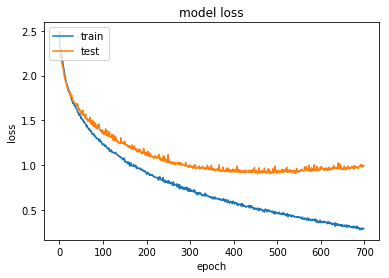

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [140]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\Users\shash\Desktop\acehacks\saved_models\Emotion_Voice_Detection_Model.h5 


In [141]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [142]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
compile_metrics: 42.86%


## Predicting emotions on the test data

In [144]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [145]:
preds

array([[0.6311464 , 0.1542578 , 0.12019971, 0.05440807, 0.03998803],
       [0.24370798, 0.06577628, 0.31543183, 0.28157282, 0.09351104],
       [0.11744311, 0.12345637, 0.17381677, 0.31155685, 0.27372694],
       [0.14212696, 0.34982702, 0.26524955, 0.09495731, 0.14783916],
       [0.06346162, 0.34739372, 0.05322298, 0.19040231, 0.34551936],
       [0.05907721, 0.30974978, 0.04364551, 0.17084144, 0.41668603],
       [0.10314906, 0.25893065, 0.10435086, 0.170467  , 0.36310247]],
      dtype=float32)

In [146]:
preds1=preds.argmax(axis=1)

In [147]:
preds1

array([0, 2, 3, 1, 1, 4, 4], dtype=int64)

In [148]:
abc = preds1.astype(int).flatten()

In [149]:
predictions = (lb.inverse_transform((abc)))

In [150]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_angry
1,male_fearful
2,male_happy
3,male_calm
4,male_calm
5,male_sad
6,male_sad


In [151]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [152]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_angry
1,male_angry
2,male_sad
3,male_calm
4,male_calm
5,male_fearful
6,male_happy


In [153]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [155]:
finaldf[0:10]

,actualvalues,predictedvalues
0,male_angry,male_angry
1,male_angry,male_fearful
2,male_sad,male_happy
3,male_calm,male_calm
4,male_calm,male_calm
5,male_fearful,male_sad
6,male_happy,male_sad


In [156]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_angry,2
male_calm,2
male_fearful,1
male_happy,1
male_sad,1


In [157]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_angry,1
male_calm,2
male_fearful,1
male_happy,1
male_sad,2


In [158]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [174]:
data, sampling_rate = librosa.load('03-01-03-01-02-01-03.wav')

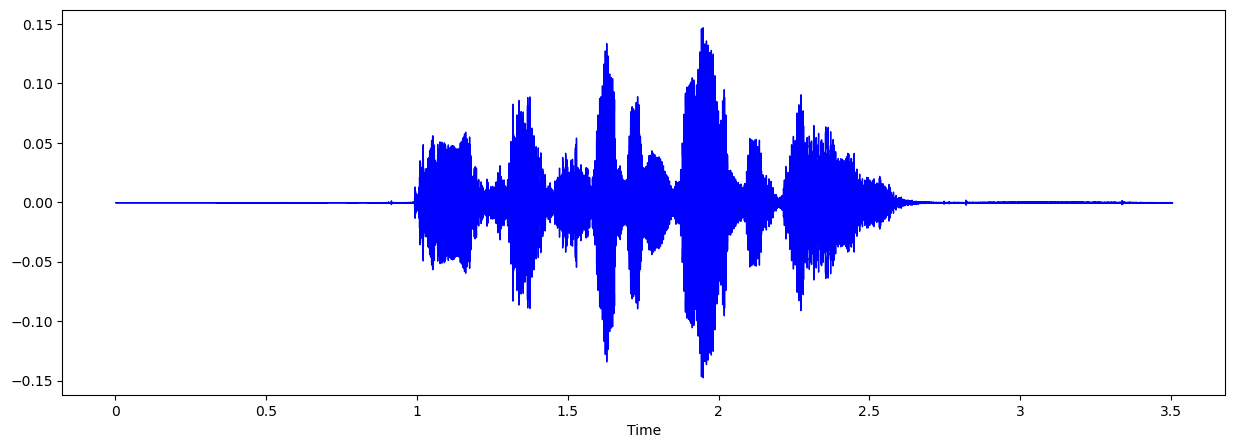

In [175]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate, color="blue")

In [176]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('03-01-03-01-02-01-03.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [177]:
livedf2= pd.DataFrame(data=livedf2)

In [178]:
livedf2 = livedf2.stack().to_frame().T

In [179]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-54.51495,-54.51495,-54.51495,-54.526299,-54.5378,-54.706455,-54.679832,-54.555088,-54.51495,-54.517647,...,-48.660702,-47.733665,-49.023418,-49.438839,-48.092144,-46.47366,-45.533134,-43.896019,-47.097549,-50.292961


In [180]:
twodim= np.expand_dims(livedf2, axis=2)

In [181]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [182]:
livepreds

array([[0.11081337, 0.05797515, 0.0837879 , 0.32209477, 0.42532876]],
      dtype=float32)

In [183]:
livepreds1=livepreds.argmax(axis=1)

In [184]:
liveabc = livepreds1.astype(int).flatten()

In [185]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_sad'], dtype=object)